# 02: Tokenizer Training & Dead Token Census

**Goals:**

1. Train TWO separate BPE tokenizers: English (2,048 tokens) and Thai (2,048 tokens)
2. Merge them into one balanced tokenizer (~4,096 tokens)
3. Tokenize the model corpus (English-only) to find dead tokens
4. **Find the magic number:** Should be ~2,048 dead tokens (all Thai)

## Why Train Separately and Merge?

Training on a mixed corpus gives unbalanced results—BPE learns more merges for whichever language has more "merge opportunities" in the training data. By training separately, we guarantee:

- Exactly ~2,048 English-derived tokens
- Exactly ~2,048 Thai-derived tokens
- Equal "quality" of merges for each language
- A perfectly balanced vocabulary by construction

This is valid per XLM-V's budget allocation methodology and the "Parallel Tokenizers" (2025) approach.

## Pre-tokenizer: Metaspace

We use Metaspace (like Llama/SentencePiece) so spaces become `▁` prefixes. The model explicitly learns whitespace without vocabulary bloat.

## Parameters

In [2]:
# Input corpora (from 01_corpora.ipynb)
TOKENIZER_CORPUS_PATH = "data/tokenizer_corpus.txt"
MODEL_CORPUS_PATH = "data/model_corpus.txt"

# Output
DATA_DIR = "data"
TOKENIZER_PATH = f"{DATA_DIR}/tokenizer.json"
CENSUS_PATH = f"{DATA_DIR}/token_census.json"
TOKENS_PATH = f"{DATA_DIR}/model_corpus_tokens.safetensors"  # Cached tokenized corpus

# Tokenizer parameters - each language gets half!
VOCAB_SIZE_PER_LANG = 2048
MIN_FREQUENCY = 2

# Special tokens (shared)
SPECIAL_TOKENS = ["<|endoftext|>"]

## Imports

In [3]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders
from safetensors.torch import save_file, load_file
from pathlib import Path
from collections import Counter
import json
import time
import tempfile
import torch

import matplotlib.pyplot as plt
import numpy as np

print("✓ Imports complete")

✓ Imports complete


## Load and Split Tokenizer Corpus

We need to separate English and Thai text to train separate tokenizers.

In [4]:
print(f"Loading tokenizer corpus from {TOKENIZER_CORPUS_PATH}...")

with open(TOKENIZER_CORPUS_PATH, 'r', encoding='utf-8') as f:
    full_text = f.read()

# Split into documents
documents = full_text.split('\n\n')
print(f"  Total documents: {len(documents):,}")

def has_thai(text: str) -> bool:
    """Check if text contains Thai characters."""
    return any(0x0E00 <= ord(c) <= 0x0E7F for c in text)

# Separate by language
english_docs = [doc for doc in documents if not has_thai(doc) and doc.strip()]
thai_docs = [doc for doc in documents if has_thai(doc) and doc.strip()]

english_text = '\n\n'.join(english_docs)
thai_text = '\n\n'.join(thai_docs)

print(f"\n✓ Split corpus:")
print(f"  English: {len(english_docs):,} docs, {len(english_text):,} chars")
print(f"  Thai: {len(thai_docs):,} docs, {len(thai_text):,} chars")

Loading tokenizer corpus from data/tokenizer_corpus.txt...
  Total documents: 24,938

✓ Split corpus:
  English: 16,210 docs, 52,179,804 chars
  Thai: 8,621 docs, 18,097,913 chars


In [5]:
# Analyze character sets
english_chars = set(english_text)
thai_chars_in_text = set(thai_text)

# Thai script range
thai_script = set(c for c in thai_chars_in_text if 0x0E00 <= ord(c) <= 0x0E7F)
ascii_chars = set(c for c in english_chars if ord(c) < 128)

# Shared characters (digits, punctuation in both)
shared_chars = english_chars & thai_chars_in_text

print(f"Character analysis:")
print(f"  English unique chars: {len(english_chars):,}")
print(f"  Thai unique chars: {len(thai_chars_in_text):,}")
print(f"  Thai script chars: {len(thai_script):,}")
print(f"  ASCII chars: {len(ascii_chars):,}")
print(f"  Shared chars: {len(shared_chars):,} (digits, punctuation, whitespace)")

Character analysis:
  English unique chars: 97
  Thai unique chars: 127
  Thai script chars: 84
  ASCII chars: 96
  Shared chars: 42 (digits, punctuation, whitespace)


## Train English Tokenizer

In [6]:
print(f"\n" + "="*70)
print(f"TRAINING ENGLISH TOKENIZER")
print(f"="*70)

# Write English text to temp file (tokenizers library needs a file)
with tempfile.NamedTemporaryFile(mode='w', suffix='.txt', delete=False, encoding='utf-8') as f:
    f.write(english_text)
    english_temp_path = f.name

# Create English tokenizer
english_tokenizer = Tokenizer(models.BPE())
english_tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()
english_tokenizer.decoder = decoders.Metaspace()

english_trainer = trainers.BpeTrainer(
    vocab_size=VOCAB_SIZE_PER_LANG,
    min_frequency=MIN_FREQUENCY,
    special_tokens=SPECIAL_TOKENS,
    show_progress=True,
    initial_alphabet=list(english_chars)
)

print(f"  Target vocabulary: {VOCAB_SIZE_PER_LANG:,} tokens")
print(f"  Base characters: {len(english_chars):,}")
print(f"\nTraining...")

start_time = time.time()
english_tokenizer.train(files=[english_temp_path], trainer=english_trainer)
elapsed = time.time() - start_time

print(f"\n✓ English tokenizer complete in {elapsed:.1f}s")
print(f"  Vocabulary size: {english_tokenizer.get_vocab_size():,} tokens")

# Clean up temp file
Path(english_temp_path).unlink()


TRAINING ENGLISH TOKENIZER
  Target vocabulary: 2,048 tokens
  Base characters: 97

Training...




✓ English tokenizer complete in 3.1s
  Vocabulary size: 2,048 tokens


## Train Thai Tokenizer

In [7]:
print(f"\n" + "="*70)
print(f"TRAINING THAI TOKENIZER")
print(f"="*70)

# Write Thai text to temp file
with tempfile.NamedTemporaryFile(mode='w', suffix='.txt', delete=False, encoding='utf-8') as f:
    f.write(thai_text)
    thai_temp_path = f.name

# Create Thai tokenizer
thai_tokenizer = Tokenizer(models.BPE())
thai_tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()
thai_tokenizer.decoder = decoders.Metaspace()

thai_trainer = trainers.BpeTrainer(
    vocab_size=VOCAB_SIZE_PER_LANG,
    min_frequency=MIN_FREQUENCY,
    special_tokens=[],  # Don't duplicate special tokens
    show_progress=True,
    initial_alphabet=list(thai_chars_in_text)
)

print(f"  Target vocabulary: {VOCAB_SIZE_PER_LANG:,} tokens")
print(f"  Base characters: {len(thai_chars_in_text):,}")
print(f"\nTraining...")

start_time = time.time()
thai_tokenizer.train(files=[thai_temp_path], trainer=thai_trainer)
elapsed = time.time() - start_time

print(f"\n✓ Thai tokenizer complete in {elapsed:.1f}s")
print(f"  Vocabulary size: {thai_tokenizer.get_vocab_size():,} tokens")

# Clean up temp file
Path(thai_temp_path).unlink()


TRAINING THAI TOKENIZER
  Target vocabulary: 2,048 tokens
  Base characters: 127

Training...




✓ Thai tokenizer complete in 8.0s
  Vocabulary size: 2,048 tokens


## Merge Tokenizers

Now the fun part: combine the two vocabularies and merge rules.

In [8]:
print(f"\n" + "="*70)
print(f"MERGING TOKENIZERS")
print(f"="*70)

# Get vocabularies
english_vocab = english_tokenizer.get_vocab()
thai_vocab = thai_tokenizer.get_vocab()

print(f"\nBefore merge:")
print(f"  English vocab: {len(english_vocab):,} tokens")
print(f"  Thai vocab: {len(thai_vocab):,} tokens")

# Find overlap (shared characters: digits, punctuation, ▁, etc.)
overlap = set(english_vocab.keys()) & set(thai_vocab.keys())
print(f"  Overlap: {len(overlap):,} tokens")

# Show what's overlapping
print(f"\n  Overlapping tokens (first 20):")
for i, tok in enumerate(sorted(overlap)[:20]):
    print(f"    {repr(tok)}")


MERGING TOKENIZERS

Before merge:
  English vocab: 2,048 tokens
  Thai vocab: 2,048 tokens
  Overlap: 108 tokens

  Overlapping tokens (first 20):
    '\n'
    ' '
    '!'
    '!!'
    '"'
    '"\n'
    '#'
    '$'
    '%'
    '&'
    "'"
    '('
    ')'
    ')\n'
    '*'
    '+'
    ','
    ',000'
    '-'
    '-0'


In [9]:
# Build merged vocabulary
# Strategy: 
# 1. Start with English vocab (IDs 0 to N-1)
# 2. Add Thai tokens that aren't in English (IDs N to M)

merged_vocab = {}
next_id = 0

# Add all English tokens first
english_tokens_sorted = sorted(english_vocab.items(), key=lambda x: x[1])
for token, old_id in english_tokens_sorted:
    merged_vocab[token] = next_id
    next_id += 1

english_end_id = next_id
print(f"Added {english_end_id} English tokens (IDs 0-{english_end_id-1})")

# Add Thai tokens that aren't already in the vocab
thai_tokens_sorted = sorted(thai_vocab.items(), key=lambda x: x[1])
thai_added = 0
for token, old_id in thai_tokens_sorted:
    if token not in merged_vocab:
        merged_vocab[token] = next_id
        next_id += 1
        thai_added += 1

print(f"Added {thai_added} Thai tokens (IDs {english_end_id}-{next_id-1})")
print(f"Skipped {len(thai_vocab) - thai_added} duplicate tokens")
print(f"\nTotal merged vocabulary: {len(merged_vocab):,} tokens")

Added 2048 English tokens (IDs 0-2047)
Added 1940 Thai tokens (IDs 2048-3987)
Skipped 108 duplicate tokens

Total merged vocabulary: 3,988 tokens


In [10]:
# Now we need to get the merge rules from both tokenizers
# We'll save them to JSON and extract the merges

import tempfile

# Save English tokenizer to get its structure
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    english_tokenizer.save(f.name)
    with open(f.name, 'r') as rf:
        english_json = json.load(rf)
    Path(f.name).unlink()

# Save Thai tokenizer
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    thai_tokenizer.save(f.name)
    with open(f.name, 'r') as rf:
        thai_json = json.load(rf)
    Path(f.name).unlink()

english_merges = english_json['model']['merges']
thai_merges = thai_json['model']['merges']

print(f"Merge rules:")
print(f"  English: {len(english_merges):,} merges")
print(f"  Thai: {len(thai_merges):,} merges")

Merge rules:
  English: 1,949 merges
  Thai: 1,920 merges


In [11]:
# Combine merges
# Since English and Thai use non-overlapping scripts, their merges won't conflict
# We'll put English merges first, then Thai merges

# Merges are lists like ["a", "b"] - convert to tuples for hashing
english_merge_tuples = [tuple(m) if isinstance(m, list) else m for m in english_merges]
thai_merge_tuples = [tuple(m) if isinstance(m, list) else m for m in thai_merges]

english_merge_set = set(english_merge_tuples)
thai_merge_set = set(thai_merge_tuples)
merge_conflicts = english_merge_set & thai_merge_set

print(f"Merge conflicts: {len(merge_conflicts)}")
if merge_conflicts:
    print(f"  Conflicting merges (first 10): {list(merge_conflicts)[:10]}")

# Combine: English first, then Thai (minus any duplicates)
combined_merges = english_merges.copy()
for merge, merge_tuple in zip(thai_merges, thai_merge_tuples):
    if merge_tuple not in english_merge_set:
        combined_merges.append(merge)

print(f"\nCombined merges: {len(combined_merges):,}")

Merge conflicts: 62
  Conflicting merges (first 10): [('▁', '\n'), ('▁', '#'), ('.', '\n'), ('▁2', '5'), ('▁1', '3'), ('▁', '5'), ('▁', "'"), ('▁1', '9'), ('▁1', '0'), ('▁2', '4')]

Combined merges: 3,807


In [12]:
# Build the merged tokenizer JSON
merged_json = {
    "version": "1.0",
    "truncation": None,
    "padding": None,
    "added_tokens": english_json.get('added_tokens', []),
    "normalizer": english_json.get('normalizer'),
    "pre_tokenizer": english_json.get('pre_tokenizer'),
    "post_processor": english_json.get('post_processor'),
    "decoder": english_json.get('decoder'),
    "model": {
        "type": "BPE",
        "dropout": None,
        "unk_token": None,
        "continuing_subword_prefix": None,
        "end_of_word_suffix": None,
        "fuse_unk": False,
        "byte_fallback": False,
        "vocab": merged_vocab,
        "merges": combined_merges
    }
}

# Save merged tokenizer
with open(TOKENIZER_PATH, 'w') as f:
    json.dump(merged_json, f, indent=2, ensure_ascii=False)

print(f"✓ Saved merged tokenizer to {TOKENIZER_PATH}")

✓ Saved merged tokenizer to data/tokenizer.json


In [13]:
# Load it back to verify it works
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)

print(f"\n✓ Loaded merged tokenizer")
print(f"  Vocabulary size: {tokenizer.get_vocab_size():,} tokens")

# Quick sanity check
test_english = "The quick brown fox"
test_thai = "สวัสดีครับ"

enc_en = tokenizer.encode(test_english)
enc_th = tokenizer.encode(test_thai)

print(f"\nSanity check:")
print(f"  '{test_english}' → {len(enc_en.ids)} tokens: {enc_en.ids[:10]}")
print(f"  '{test_thai}' → {len(enc_th.ids)} tokens: {enc_th.ids[:10]}")


✓ Loaded merged tokenizer
  Vocabulary size: 3,988 tokens

Sanity check:
  'The quick brown fox' → 6 tokens: [192, 1681, 1336, 526, 120, 1446]
  'สวัสดีครับ' → 5 tokens: [2168, 2407, 2089, 2236, 2637]


## Classify Tokens by Script

In [14]:
def classify_token(token: str) -> str:
    """Classify a token as latin, thai, common, or special."""
    if token in SPECIAL_TOKENS:
        return 'special'
    
    has_latin = any(c.isascii() and c.isalpha() for c in token)
    has_thai = any(0x0E00 <= ord(c) <= 0x0E7F for c in token)
    
    if has_thai and has_latin:
        return 'mixed'
    elif has_thai:
        return 'thai'
    elif has_latin:
        return 'latin'
    else:
        return 'common'  # punctuation, numbers, whitespace

# Classify all tokens
vocab = tokenizer.get_vocab()
token_classes = {idx: classify_token(token) for token, idx in vocab.items()}

# Count by category
class_counts = Counter(token_classes.values())

print(f"Token classification:")
print(f"="*50)
for cls in ['latin', 'thai', 'mixed', 'common', 'special']:
    count = class_counts.get(cls, 0)
    pct = 100 * count / len(vocab)
    print(f"  {cls:10s}: {count:,} ({pct:.1f}%)")

# Store for later
thai_token_ids = {idx for idx, cls in token_classes.items() if cls == 'thai'}
latin_token_ids = {idx for idx, cls in token_classes.items() if cls == 'latin'}
print(f"\n→ {len(thai_token_ids):,} Thai-script tokens")
print(f"→ {len(latin_token_ids):,} Latin-script tokens")

Token classification:
  latin     : 1,913 (48.0%)
  thai      : 1,904 (47.7%)
  mixed     : 0 (0.0%)
  common    : 170 (4.3%)
  special   : 1 (0.0%)

→ 1,904 Thai-script tokens
→ 1,913 Latin-script tokens


---

# The Magic Number: Dead Token Census

Now we tokenize the model corpus and find out exactly how many tokens never appear.

In [15]:
print(f"Loading model corpus from {MODEL_CORPUS_PATH}...")

with open(MODEL_CORPUS_PATH, 'r', encoding='utf-8') as f:
    model_text = f.read()

print(f"  Size: {len(model_text):,} characters")

print(f"\nTokenizing model corpus...")
start_time = time.time()
encoding = tokenizer.encode(model_text)
elapsed = time.time() - start_time

model_tokens = encoding.ids
print(f"\n✓ Tokenized in {elapsed:.1f} seconds")
print(f"  Total tokens: {len(model_tokens):,}")

Loading model corpus from data/model_corpus.txt...
  Size: 104,320,221 characters

Tokenizing model corpus...

✓ Tokenized in 31.9 seconds
  Total tokens: 34,993,926


In [16]:
# Cache tokenized corpus for fast loading in experiments
# This saves ~30 seconds on every notebook that needs the corpus

model_tokens_tensor = torch.tensor(model_tokens, dtype=torch.int32)

save_file({"tokens": model_tokens_tensor}, TOKENS_PATH)

print(f"✓ Cached tokenized corpus to {TOKENS_PATH}")
print(f"  Shape: {model_tokens_tensor.shape}")
print(f"  Dtype: {model_tokens_tensor.dtype}")
print(f"  Size: {Path(TOKENS_PATH).stat().st_size / 1e6:.1f} MB")

✓ Cached tokenized corpus to data/model_corpus_tokens.safetensors
  Shape: torch.Size([34993926])
  Dtype: torch.int32
  Size: 140.0 MB


In [17]:
# Count token frequencies
token_counts = Counter(model_tokens)

# Find tokens that NEVER appear
all_token_ids = set(range(tokenizer.get_vocab_size()))
used_token_ids = set(token_counts.keys())
dead_token_ids = all_token_ids - used_token_ids

print(f"\n" + "="*70)
print(f"THE MAGIC NUMBER")
print(f"="*70)
print(f"\nVocabulary size: {tokenizer.get_vocab_size():,}")
print(f"Tokens used in model corpus: {len(used_token_ids):,}")
print(f"\n★ DEAD TOKENS: {len(dead_token_ids):,} ★")
print(f"\n  (These tokens will never receive gradient signal during training)")


THE MAGIC NUMBER

Vocabulary size: 3,988
Tokens used in model corpus: 2,074

★ DEAD TOKENS: 1,914 ★

  (These tokens will never receive gradient signal during training)


In [18]:
# Break down dead tokens by type
dead_by_class = Counter(token_classes[idx] for idx in dead_token_ids)

print(f"\nDead token breakdown:")
print(f"="*50)
for cls in ['thai', 'latin', 'common', 'mixed', 'special']:
    count = dead_by_class.get(cls, 0)
    if count > 0:
        pct_of_dead = 100 * count / len(dead_token_ids)
        pct_of_class = 100 * count / class_counts.get(cls, 1)
        print(f"  {cls:10s}: {count:,} ({pct_of_dead:.1f}% of dead, {pct_of_class:.1f}% of all {cls})")

# Summary: How many of each category are dead vs alive?
print(f"\nDead rate by category:")
print(f"="*50)
for cls in ['thai', 'latin', 'common', 'mixed', 'special']:
    total = class_counts.get(cls, 0)
    if total > 0:
        dead = dead_by_class.get(cls, 0)
        dead_pct = 100 * dead / total
        print(f"  {cls:10s}: {dead:,}/{total:,} dead ({dead_pct:.1f}%)")


Dead token breakdown:
  thai      : 1,904 (99.5% of dead, 100.0% of all thai)
  common    : 9 (0.5% of dead, 5.3% of all common)
  special   : 1 (0.1% of dead, 100.0% of all special)

Dead rate by category:
  thai      : 1,904/1,904 dead (100.0%)
  latin     : 0/1,913 dead (0.0%)
  common    : 9/170 dead (5.3%)
  special   : 1/1 dead (100.0%)


## Frequency Histogram

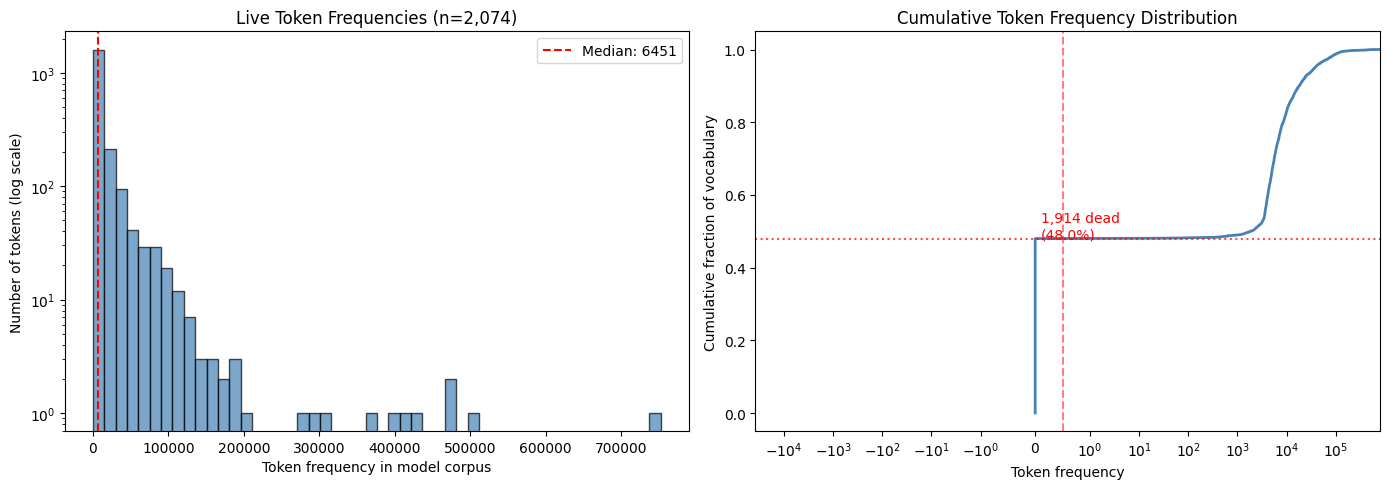


✓ Saved histogram to data/token_frequency_histogram.png


In [19]:
# Get frequencies for all tokens (0 for dead ones)
all_frequencies = [token_counts.get(idx, 0) for idx in range(tokenizer.get_vocab_size())]

# Separate live and dead
live_frequencies = [f for f in all_frequencies if f > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Log-scale histogram of live token frequencies
ax1 = axes[0]
ax1.hist(live_frequencies, bins=50, log=True, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Token frequency in model corpus')
ax1.set_ylabel('Number of tokens (log scale)')
ax1.set_title(f'Live Token Frequencies (n={len(live_frequencies):,})')
ax1.axvline(np.median(live_frequencies), color='red', linestyle='--', label=f'Median: {np.median(live_frequencies):.0f}')
ax1.legend()

# Right: Cumulative distribution showing dead vs live
ax2 = axes[1]
sorted_freqs = sorted(all_frequencies)
cumulative = np.arange(1, len(sorted_freqs) + 1) / len(sorted_freqs)
ax2.plot(sorted_freqs, cumulative, color='steelblue', linewidth=2)
ax2.axvline(0.5, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Token frequency')
ax2.set_ylabel('Cumulative fraction of vocabulary')
ax2.set_title(f'Cumulative Token Frequency Distribution')
ax2.set_xscale('symlog', linthresh=1)

# Annotate dead fraction
dead_frac = len(dead_token_ids) / tokenizer.get_vocab_size()
ax2.axhline(dead_frac, color='red', linestyle=':', alpha=0.7)
ax2.annotate(f'{len(dead_token_ids):,} dead\n({100*dead_frac:.1f}%)', 
             xy=(0.1, dead_frac), fontsize=10, color='red')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/token_frequency_histogram.png', dpi=150)
plt.show()

print(f"\n✓ Saved histogram to {DATA_DIR}/token_frequency_histogram.png")

## Sample Dead Tokens

In [20]:
# Show some example dead tokens
print(f"\nSample dead tokens (first 30):")
print()

id_to_token = {v: k for k, v in vocab.items()}

dead_list = sorted(dead_token_ids)
for idx in dead_list[:30]:
    token = id_to_token[idx]
    cls = token_classes[idx]
    print(f"  {idx:4d}: {repr(token):20s} [{cls}]")


Sample dead tokens (first 30):

     0: '<|endoftext|>'      [special]
     2: ' '                  [common]
    97: '–'                  [common]
  2048: 'ก'                  [thai]
  2049: 'ข'                  [thai]
  2050: 'ฃ'                  [thai]
  2051: 'ค'                  [thai]
  2052: 'ฅ'                  [thai]
  2053: 'ฆ'                  [thai]
  2054: 'ง'                  [thai]
  2055: 'จ'                  [thai]
  2056: 'ฉ'                  [thai]
  2057: 'ช'                  [thai]
  2058: 'ซ'                  [thai]
  2059: 'ฌ'                  [thai]
  2060: 'ญ'                  [thai]
  2061: 'ฎ'                  [thai]
  2062: 'ฏ'                  [thai]
  2063: 'ฐ'                  [thai]
  2064: 'ฑ'                  [thai]
  2065: 'ฒ'                  [thai]
  2066: 'ณ'                  [thai]
  2067: 'ด'                  [thai]
  2068: 'ต'                  [thai]
  2069: 'ถ'                  [thai]
  2070: 'ท'                  [thai]
  2071: 'ธ'             

## Save Census Data

In [21]:
# Save the important numbers for future reference
census = {
    'vocab_size': tokenizer.get_vocab_size(),
    'model_corpus_tokens': len(model_tokens),
    'live_tokens': len(used_token_ids),
    'dead_tokens': len(dead_token_ids),
    'dead_token_ids': sorted(dead_token_ids),
    'thai_tokens': len(thai_token_ids),
    'latin_tokens': len(latin_token_ids),
    'dead_thai_tokens': len(dead_token_ids & thai_token_ids),
    'dead_latin_tokens': len(dead_token_ids & latin_token_ids),
    'class_counts': dict(class_counts),
    'dead_by_class': dict(dead_by_class),
}

with open(CENSUS_PATH, 'w') as f:
    json.dump(census, f, indent=2)

print(f"✓ Saved census data to {CENSUS_PATH}")

✓ Saved census data to data/token_census.json


## Summary

In [ ]:
print(f"\n" + "="*70)
print(f"TOKENIZER TRAINING COMPLETE")
print(f"="*70)

print(f"\nApproach: Train separately, merge programmatically")
print(f"  English tokenizer: {VOCAB_SIZE_PER_LANG:,} tokens")
print(f"  Thai tokenizer: {VOCAB_SIZE_PER_LANG:,} tokens")
print(f"  Overlap (shared chars): {len(overlap):,} tokens")

print(f"\nMerged tokenizer:")
print(f"  Path: {TOKENIZER_PATH}")
print(f"  Total vocabulary: {tokenizer.get_vocab_size():,} tokens")
print(f"  Thai tokens: {len(thai_token_ids):,}")
print(f"  Latin tokens: {len(latin_token_ids):,}")

print(f"\nModel corpus tokenization:")
print(f"  Total tokens: {len(model_tokens):,}")
print(f"  Unique tokens used: {len(used_token_ids):,}")
print(f"  Cached to: {TOKENS_PATH}")

print(f"\n" + "*"*70)
print(f"★ THE MAGIC NUMBER: {len(dead_token_ids):,} DEAD TOKENS ★")
print(f"*"*70)

print(f"\nDead token breakdown:")
print(f"  Thai: {dead_by_class.get('thai', 0):,} ({100*dead_by_class.get('thai', 0)/max(len(thai_token_ids),1):.1f}% of Thai tokens)")
print(f"  Latin: {dead_by_class.get('latin', 0):,} ({100*dead_by_class.get('latin', 0)/max(len(latin_token_ids),1):.1f}% of Latin tokens)")

print(f"\nOutputs:")
print(f"  {TOKENIZER_PATH} — merged tokenizer")
print(f"  {CENSUS_PATH} — dead token census")
print(f"  {TOKENS_PATH} — cached tokenized corpus (fast load)")

print(f"\nNext steps:")
print(f"  → 03_efficiency_cliff.ipynb: Find optimal batch size")
print(f"  → These {len(dead_token_ids):,} tokens will be our frozen smoke candidates")
print(f"="*70)


TOKENIZER TRAINING COMPLETE

Approach: Train separately, merge programmatically
  English tokenizer: 2,048 tokens
  Thai tokenizer: 2,048 tokens
  Overlap (shared chars): 108 tokens

Merged tokenizer:
  Path: data/tokenizer.json
  Total vocabulary: 3,988 tokens
  Thai tokens: 1,904
  Latin tokens: 1,913

Model corpus tokenization:
  Total tokens: 34,993,926
  Unique tokens used: 2,074
  Cached to: data/model_corpus_tokens.safetensors

**********************************************************************
★ THE MAGIC NUMBER: 1,914 DEAD TOKENS ★
**********************************************************************

Dead token breakdown:
  Thai: 1,904 (100.0% of Thai tokens)
  Latin: 0 (0.0% of Latin tokens)

Outputs:
  data/tokenizer.json — merged tokenizer
  data/token_census.json — dead token census
  data/model_corpus_tokens.safetensors — cached tokenized corpus (fast load)

Next steps:
  → 03_efficiency_cliff.ipynb: Find optimal batch size
  → These 1,914 tokens will be our frozen 

: 